In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
gr      = 1.618
nan     = -2147483648
min_root_size = 20000 # Skip root files smaller than x bytes

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV

# dead wires
z_dead_start = 675
z_dead_end=z_dead_start+100

# Minimum reconstructable energies:
min_e = 0.02+mass_e # 20MeV
min_p = 0.04+mass_p # 40MeV
min_pi = 0.17

vtx_activity_cut = 5

In [3]:
gpvmsdir = '/run/user/1002/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp'
# Option 1: no checkana, verify validity yourself and use input directory
inputlist = []
#inputlist += glob.glob("/home/wouter/Templates/lee_signal_75k_0s0t/*.root")
inputlist += glob.glob("/home/wouter/Templates/May/bnb_nue_cosmic_0s0t_dev/*.root")
filelist  = []
for fname in inputlist:
    if (os.stat(fname).st_size)<min_root_size:
            print("File",fname,"was corrupt. Size:",os.stat(fname).st_size/1000, "kb, skipping to next file.")
    else:
        filelist.append(fname)

In [4]:
print(len(filelist))

283


In [5]:
def true_thresholds_1e1p(row):
    isProton = False
    isPion = False
    if row["true_1eX_signal"]:
        for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
            if pdg==2212 and E>min_p:
                isProton = True
            if pdg in [-211,211,111] and E>min_pi:
                isPion = True
    return isProton and not isPion


# Formatting
def sciNot(x):
    x=float(x)
    return "{:.1f}".format(x)

def sciNot2(x):
    x=float(x)
    return "{:.2f}".format(x)

# error unweighter
def effErr(teller,noemer):
    return np.sqrt(teller*(1-teller/noemer))/noemer

def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    #r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(x, y)
    return theta, phi#, r

In [6]:
if 1:
    from root_pandas import read_root
    chunks = []
    
    true_proton = []
    sh_proton = []
    tr_proton = []

    for i_f,fname in enumerate(filelist[:]):
        print (i_f)
        dftemp=read_root(fname,"wouterNueCC/pandoratree",columns=["true_1eX_signal","bnbweight", "nu_E","shower_vtxdistance","track_vtxdistance",
                                                                  "true_vz",
                                                                  "matched_showers", "matched_showers_energy", "shower_theta", "shower_phi",
                                                                  "matched_tracks", "matched_tracks_energy", "track_theta", "track_phi",
                                                                  "nu_daughters_pdg","nu_daughters_E", "nu_daughters_px", "nu_daughters_py", "nu_daughters_pz",
                                                                  "nu_pdg",
                                                                  "fiducial","vz","n_tracks","candidate_pdg","numu_passed",
                                                                  'passed','category',"n_showers"])
        
        # Fill proton arrays
        for index, row in dftemp.iterrows():
            if row["true_1eX_signal"]==1:
            ## Truth ones
                for pdg,E,px,py,pz in zip(*row[["nu_daughters_pdg","nu_daughters_E", "nu_daughters_px", "nu_daughters_py", "nu_daughters_pz"]]):
                    if pdg==2212 and E>(mass_p+0.04):
                        theta,phi = cart2sph(px, py, pz)
                        true_proton.append([E-mass_p,theta,phi]) 

            ## Reco ones
                if row["category"]==2 and row["candidate_pdg"]==12  and row["passed"]==1 and row["fiducial"]==1 :
                    ### Showers
                    for pdg,E,theta,phi in zip(*row[["matched_showers", "matched_showers_energy", "shower_theta", "shower_phi"]]):
                        if pdg==2212 and E>(mass_p+0.04):
                            sh_proton.append([E-mass_p,theta,phi]) 
                    ### Track
                    for pdg,E,theta,phi in zip(*row[["matched_tracks", "matched_tracks_energy", "track_theta", "track_phi"]]):
                        if pdg==2212 and E>(mass_p+0.04):
                            tr_proton.append([E-mass_p,theta,phi]) 
                    
        chunks.append(dftemp)

    df = pd.concat(chunks,ignore_index=True,copy=False) 
    
    df["vtx_activity_nr_sh"] = df.apply(lambda x: sum(x["shower_vtxdistance"]<vtx_activity_cut),axis=1)
    df["vtx_activity_nr_tr"] = df.apply(lambda x: sum(x["track_vtxdistance"]<vtx_activity_cut),axis=1)
    df["vtx_activity_nr"] = df["vtx_activity_nr_sh"]+df["vtx_activity_nr_tr"]
    df["reco_z_deadwire"] = ~df['vz'].between(z_dead_start,z_dead_end)
    df["true_z_deadwire"] = ~df['true_vz'].between(z_dead_start,z_dead_end)
    df["true_1e1p_signal"] = df.apply(true_thresholds_1e1p,axis=1)
    
    
    df.drop(["nu_daughters_pdg","nu_daughters_E","shower_vtxdistance","track_vtxdistance"],inplace=True,axis=1)
    df.to_pickle("df_nue.pckl")
    
    true_proton = np.transpose(np.array(true_proton))
    tr_proton = np.transpose(np.array(tr_proton))
    sh_proton = np.transpose(np.array(sh_proton))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

51927
4391
14246


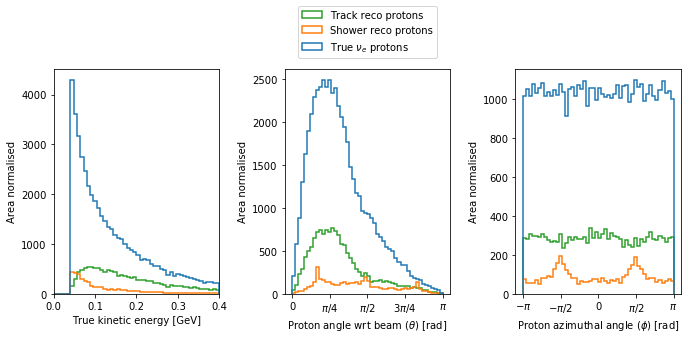

In [15]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6*gr,4),sharey=False,sharex=False)

xlims = [(0,0.4),(0,np.pi),(-np.pi,np.pi)]
for i,xlim in enumerate(xlims):
    weights = [np.ones_like(true_proton[i])/float(len(true_proton[i])),
               np.ones_like(sh_proton[i])/float(len(sh_proton[i])),
               np.ones_like(tr_proton[i])/float(len(tr_proton[i])),
              ]
    
    ax[i].hist([true_proton[i],sh_proton[i],tr_proton[i]] ,bins=50,alpha=1.0,label=[r"True $\nu_e$ protons","Shower reco protons","Track reco protons"],
               normed=False, histtype='step', stacked=False, lw=1.5, range=xlim)#, weights=weights)

ax[0].set_ylabel(r"Area normalised")
ax[0].set_xlabel("True kinetic energy [GeV]")
ax[0].set_xlim(0,0.4)

ax[1].set_ylabel(r"Area normalised")
x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[1].legend(loc="upper center",bbox_to_anchor=(0.5, 1.3))
ax[1].set_xlabel(r"Proton angle wrt beam ($\theta$) [rad]")

x_labels = [r'$-{\pi}$',r'$-{\pi}/{2}$',r'0', r'${\pi}/{2}$', r'${\pi}$']
x_ticks = [-np.pi,-np.pi/2,0,np.pi/2,np.pi]
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_labels)
ax[2].set_ylabel(r"Area normalised")
ax[2].set_xlabel(r"Proton azimuthal angle ($\phi$) [rad]")

fig.tight_layout()
plt.savefig("../../Output/proton_theta.pdf", bbox_inches='tight', pad_inches=0.1)

print(len(true_proton[0]))
print(len(sh_proton[0]))
print(len(tr_proton[0]))

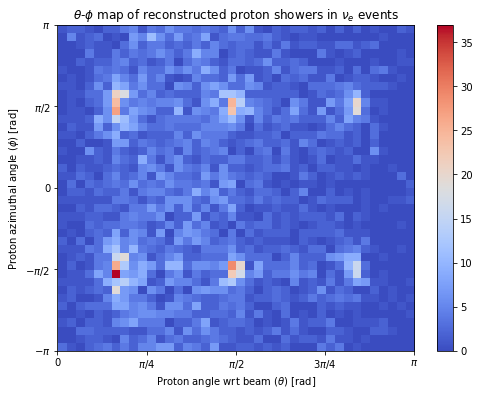

In [8]:
fig,ax=plt.subplots(figsize=(8,6))



hb = ax.hist2d(sh_proton[1], sh_proton[2], bins=40,cmap="coolwarm")
cb = fig.colorbar(hb[3], ax=ax)

x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_title(r"$\theta$-$\phi$ map of reconstructed proton showers in $\nu_e$ events")
y_labels = [r'$-{\pi}$',r'$-{\pi}/{2}$',r'0', r'${\pi}/{2}$', r'${\pi}$']
y_ticks = [-np.pi,-np.pi/2,0,np.pi/2,np.pi]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

ax.set_xlabel(r"Proton angle wrt beam ($\theta$) [rad]")
ax.set_ylabel(r"Proton azimuthal angle ($\phi$) [rad]")
plt.savefig("../../Output/theta_phi_map.pdf", bbox_inches='tight')

In [9]:
df_tune3 = pd.read_pickle("df_nue_tune3.pckl")
df_tune1 = pd.read_pickle("df_nue_tune1.pckl")
print(len(df_tune3.index))
print(len(df_tune1.index))

FileNotFoundError: [Errno 2] No such file or directory: 'df_nue_tune3.pckl'

In [ ]:
df_tune3["nu_pdg"].value_counts()

In [ ]:
sum(df_tune3["true_1eX_signal"])

In [ ]:
str_query = "true_1eX_signal==1 & true_z_deadwire==1"
df_1eX = df_tune1.query(str_query)
df_1eX_tune3 = df_tune3.query(str_query)
df_1eX.head()

df_1eX_tune3["nu_pdg"].value_counts()

In [ ]:
df_1e1p = df_1eX.query("true_1e1p_signal==1")
df_1e1p_tune3 = df_1eX_tune3.query("true_1e1p_signal==1")
print(len(df_1e1p_tune3))
print(len(df_1e1p))

In [ ]:
str_passed = "passed==1 & fiducial==1 & reco_z_deadwire==1 & category==2"
df_passed = df_1eX.query(str_passed)
df_passed_shower = df_passed.query("vtx_activity_nr_sh>0")
df_passed_pdg = df_passed.query("candidate_pdg==12")

df_passed_2obj = df_passed_shower.query("vtx_activity_nr>1")
df_passed_pdg_2obj = df_passed_2obj.query("candidate_pdg==12")
df_passed_shtr = df_passed_shower.query("n_tracks>0")
nominators = [df_passed,df_passed_pdg,df_passed_2obj]
labels = ["Optical + fiducial cuts           ",
          "At least one shower               ",
          "1+shower and other objects "]

In [ ]:
nominators[0].head()

In [ ]:
E_denom = df_1eX["nu_E"]
weight_denom = df_1eX["bnbweight"]
E_nom = df_1e1p["nu_E"]
weight_nom = df_1e1p["bnbweight"]

E_denom_tune3 = df_1eX_tune3["nu_E"]
weight_denom_tune3 = df_1eX_tune3["bnbweight"]
E_nom_tune3 = df_1e1p_tune3["nu_E"]
weight_nom_tune3 = df_1e1p_tune3["bnbweight"]

In [ ]:
# Make the signal plot to motivate the inclusive channel 
# from a final state point of view and from a reconstruction point of view

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4.5),sharey=False,sharex=True)
N = 10
min_x = 0.2
max_x = 1.2
binwidth=(max_x-min_x)/N
halfbin = binwidth/2
step=0.2

denom, edges = np.histogram(E_denom,bins=N,range=(min_x,max_x),weights=weight_denom)
nom, _       = np.histogram(E_nom,bins=N,range=(min_x,max_x),weights=weight_nom)
eff = nom/denom

denom_tune3, _ = np.histogram(E_denom_tune3,bins=N,range=(min_x,max_x),weights=weight_denom_tune3)
nom_tune3, _       = np.histogram(E_nom_tune3,bins=N,range=(min_x,max_x),weights=weight_nom_tune3)
eff_tune3 = nom_tune3/denom_tune3


ax[0].set_title('Final State Signal Ratio')
ax[0].errorbar(edges[:-1]+halfbin, denom/denom , xerr=halfbin, yerr=effErr(denom,denom),alpha=1.0,fmt='.',label=r'1eX ($E_{kin}(e^-) > 20$MeV)')
ax[0].errorbar(edges[:-1]+halfbin, eff , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=r'1e Np 0$\pi$ ($E_{kin}(p) > 40$MeV) Tune 1')
ax[0].errorbar(edges[:-1]+halfbin, eff_tune3 , xerr=halfbin, yerr=effErr(nom_tune3,denom_tune3),alpha=1.0,fmt='.',label=r'1e Np 0$\pi$ ($E_{kin}(p) > 40$MeV) Tune 3')


ax[1].set_title('Efficiency (Reco-Truth Matched)')
ax[1].errorbar(edges[:-1]+halfbin, denom/denom , xerr=halfbin, yerr=effErr(denom,denom),alpha=1.0,fmt='.',label=r'1eX ($E_{kin}(e^-) > 20$MeV)')
for df,lab in zip(nominators,labels):
    percent = int(df[df["bnbweight"]!=1]["bnbweight"].sum()/df_1eX[df_1eX["bnbweight"]!=1]["bnbweight"].sum()*100)
    print(percent,lab)
    nom,_ = np.histogram(df["nu_E"],bins=N,range=(min_x,max_x),weights=df["bnbweight"])
    eff = nom/denom 
    ax[1].errorbar(edges[:-1]+halfbin, eff , xerr=halfbin, yerr=effErr(nom,denom),alpha=1.0,fmt='.',label=lab+"("+str(percent)+"%)")

#ax[0].set_frame_on(False)
#ax[1].set_frame_on(False)

ax[0].set_ylabel('Signal ratio ('+sciNot2(binwidth)+' GeV bins)')
ax[1].set_ylabel('Selection efficiency ('+sciNot2(binwidth)+' GeV bins)')

ax[0].set_xlim(min_x,max_x)
ax[1].set_xlim(min_x,max_x)

ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)

ax[0].set_xlabel(r'True $\nu_e$ energy [GeV]')
ax[1].set_xlabel(r'True $\nu_e$ energy [GeV]')

ax[0].legend(loc="center",bbox_to_anchor=(0.5, 0.75))
ax[1].legend(loc="center", bbox_to_anchor=(0.5, 0.75))

plt.tight_layout(w_pad=3.5)
#fig.subplots_adjust(top=0.85)
plt.savefig("../../Output/eff_pur_nue_new.pdf", bbox_inches='tight', pad_inches=0.1)